In [2]:
!pip install distance
!pip install fuzzywuzzy

     |████████████████████████████████| 184kB 30.5MB/s 
  Created wheel for distance: filename=Distance-0.1.3-cp37-none-any.whl size=16261 sha256=9304ce08f47b07d9d0f89967976b0720a96b6e4ac550db795f9e48cd1822203a
  Stored in directory: /root/.cache/pip/wheels/d5/aa/e1/dbba9e7b6d397d645d0f12db1c66dbae9c5442b39b001db18e
Successfully built distance


In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
import distance
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings("ignore")
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

In [44]:
df = pd.read_csv('/content/drive/MyDrive/Project/train.csv.zip')
df.head(8)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


36.92 % duplicated question pairs.
63.08 % non duplicated question pairs.


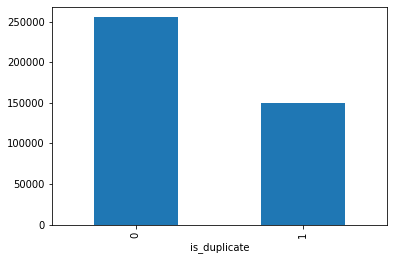

In [46]:
print( round(df['is_duplicate'].mean()*100, 2),"% duplicated question pairs.")
print(100- round(df['is_duplicate'].mean()*100, 2),"% non duplicated question pairs.")
df.groupby("is_duplicate")['id'].count().plot.bar()

In [47]:
df = df.fillna('')

## Feature Enginerring 

 - ___q1len___ = Length of q1
 - ___q2len___ = Length of q2
 - ___diff_len___ = len(q1)-len(q2)       


 - ___q1_n_words___ = Number of words in q1
 - ___q2_n_words___ = Number of words in q2
 - ___diff_n_words___ = The difference       


 - ___caps_count_q1___ = Number of capital words of q1
 - ___caps_count_q2___ = Number of capital words of q2
 - ___diff_caps___ = The difference       


 - ___len_char_q1___ = Number of characters of q1
 - ___len_char_q2___ = Number of characters of q2
 - ___diff_len_char___ = The difference      


 - ___avg_word_len1___ = len(char)/len(word) of q1
 - ___avg_word_len2___ = len(char)/len(word) of q2
 - ___diff_avg_word___ = The difference      


 - ___word_Common___ = Number of common unique words in q1 and q2
 - ___word_Total___ = Total num of words in Question 1 + Total num of words in q2
 - ___word_share___ = (word_common)/(word_Total)    
 - ___2_gram_share___ = word share on 2 gram


 - ___exactly_same___ = exactly the same



In [49]:
if os.path.isfile('/content/drive/MyDrive/Project/feature_tm.csv'):
  df = pd.read_csv('/content/drive/MyDrive/Project/feature_tm.csv',encoding='latin-1')
else:
  df['q1len'] = df.question1.str.len()
  df['q2len'] = df.question2.str.len()
  df['diff_len'] = df.q1len - df.q2len
  
  df['len_word_q1'] = df.question1.apply(lambda row: len(row.split(" ")))
  df['len_word_q2'] = df.question2.apply(lambda row: len(row.split(" ")))
  df['diff_words'] = df.len_word_q1 - df.len_word_q2
  
  df['caps_count_q1'] = df.question1.apply(lambda x:sum(1 for i in str(x) if i.isupper()))
  df['caps_count_q2'] = df.question2.apply(lambda x:sum(1 for i in str(x) if i.isupper()))
  df['diff_caps'] = df.caps_count_q1 - df.caps_count_q2
  
  df['len_char_q1'] = df.question1.apply(lambda x: len(str(x).replace(' ', '')))
  df['len_char_q2'] = df.question2.apply(lambda x: len(str(x).replace(' ', '')))
  df['diff_len_char'] = df.len_char_q1 - df.len_char_q2
  
  df['avg_world_len1'] = df.len_char_q1 / df.len_word_q1
  df['avg_world_len2'] = df.len_char_q2 / df.len_word_q2
  df['diff_avg_word'] = df.avg_world_len1 - df.avg_world_len2

  def word_common(row):
      w1 = set(map(lambda word: word.lower().strip(), row.question1.split(" ")))
      w2 = set(map(lambda word: word.lower().strip(), row.question2.split(" ")))    
      return 1.0 * len(w1 & w2)

  def word_total(row):
      w1 = set(map(lambda word: word.lower().strip(), row.question1.split(" ")))
      w2 = set(map(lambda word: word.lower().strip(), row.question2.split(" ")))    
      return 1.0 * (len(w1) + len(w2))

  def word_share(row):
      w1 = set(map(lambda word: word.lower().strip(), row.question1.split(" ")))
      w2 = set(map(lambda word: word.lower().strip(), row.question2.split(" ")))    
      return 1.0 * len(w1 & w2)/(len(w1) + len(w2))

  def get_2_gram_share(row):
      q1_list = str(row.question1).lower().split()
      q2_list = str(row.question2).lower().split()
      q1_2_gram = set([i for i in zip(q1_list, q1_list[1:])])
      q2_2_gram = set([i for i in zip(q2_list, q2_list[1:])])
      shared_2_gram = q1_2_gram.intersection(q2_2_gram)
      if len(q1_2_gram) + len(q2_2_gram) == 0:
          R2gram = 0
      else:
          R2gram = len(shared_2_gram) / (len(q1_2_gram) + len(q2_2_gram))
      return R2gram

  df['word_Common'] = df.apply(word_common, axis=1)
  df['word_Total'] = df.apply(word_total, axis=1)
  df['word_share'] = df.apply(word_share, axis=1)
  df['share_2_gram'] = df.apply(get_2_gram_share, axis=1) 

  df.to_csv('/content/drive/MyDrive/Project/feature_tm.csv', index=False)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1len,q2len,diff_len,len_word_q1,len_word_q2,diff_words,caps_count_q1,caps_count_q2,diff_caps,len_char_q1,len_char_q2,diff_len_char,avg_world_len1,avg_world_len2,diff_avg_word,word_Common,word_Total,word_share,share_2_gram
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,9,14,12,2,1,1,0,53,46,7,3.785714,3.833333,-0.047619,10.0,23.0,0.434783,0.416667
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,-37,8,13,-5,5,5,0,44,76,-32,5.500000,5.846154,-0.346154,4.0,20.0,0.200000,0.052632
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,14,10,4,5,5,0,60,50,10,4.285714,5.000000,-0.714286,4.0,24.0,0.166667,0.045455
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,-15,11,9,2,4,1,3,40,57,-17,3.636364,6.333333,-2.696970,0.0,19.0,0.000000,0.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,37,13,7,6,1,1,0,64,33,31,4.923077,4.714286,0.208791,2.0,20.0,0.100000,0.000000
